<a href="https://colab.research.google.com/github/kinjuk/market-analysis/blob/main/vix_mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-14-3510971525.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Downloaded 3773 days of VIX data
Calculating regression and deviations...

Starting backtest...


/tmp/ipython-input-14-3510971525.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vix_price = float(data['VIX'].iloc[i])
/tmp/ipython-input-14-3510971525.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vix_price = float(data['VIX'].iloc[i])
/tmp/ipython-input-14-3510971525.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vix_price = float(data['VIX'].iloc[i])
/tmp/ipython-input-14-3510971525.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vix_price = float(data['VIX'].iloc[i])
/tmp/ipython-input-14-3510971525.py:69: FutureWarning: Calling float on a single element Series is depre

Total trades executed: 333


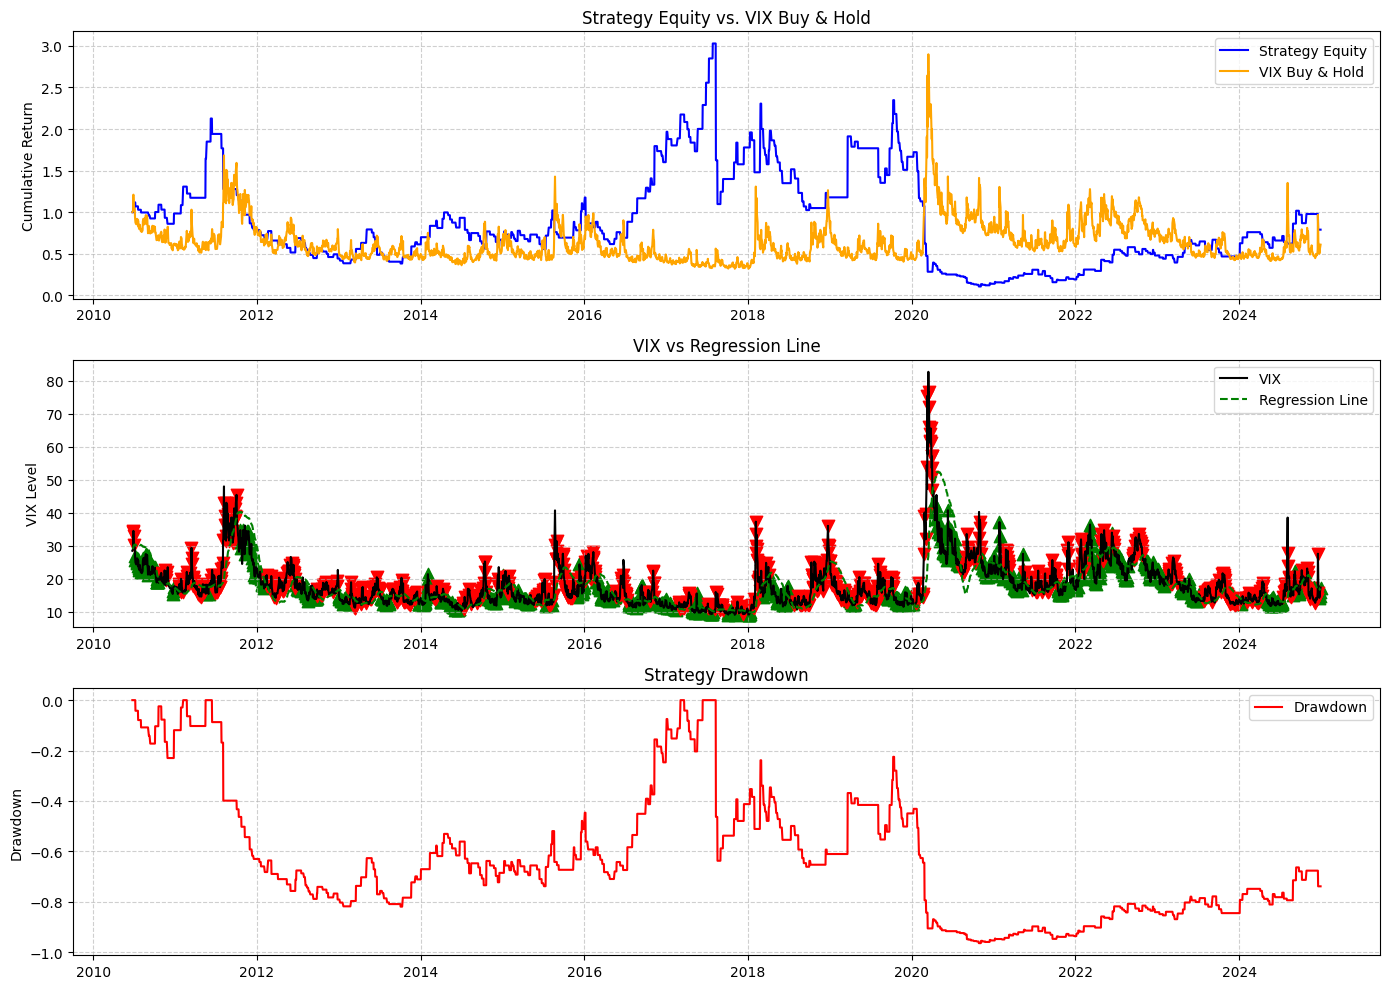


===== Strategy Performance Summary =====
Total Trades: 333
Winning Trades: 118
Losing Trades: 215
Win Rate: 35.44%
Total Return: -21.00%


In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1. Download VIX data
ticker = '^VIX'
start_date = '2010-01-01'
end_date = '2024-12-31'

data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Close']].rename(columns={'Close': 'VIX'})

# Ensure index is datetime and unique
data.index = pd.to_datetime(data.index)
data = data[~data.index.duplicated(keep='first')]

print(f"Downloaded {len(data)} days of VIX data")

# Strategy parameters
LOOKBACK_WINDOW = 120      # Days for regression calculation
DEVIATION_THRESHOLD = 10   # % deviation to trigger entry (long/short)
REVERSION_THRESHOLD = 2    # % deviation to trigger exit
MAX_HOLD_DAYS = 60         # Maximum holding period
STOP_LOSS_PCT = 0.03       # 3% stop-loss from entry VIX level
COOLDOWN_DAYS = 5          # Optional cooldown days after stop-out

# Calculate regression and deviation columns
data['Regression'] = np.nan
data['Deviation'] = np.nan

print("Calculating regression and deviations...")
for i in range(LOOKBACK_WINDOW, len(data)):
    window = data['VIX'].iloc[i-LOOKBACK_WINDOW:i]
    X = np.arange(len(window)).reshape(-1, 1)
    y = window.values
    model = LinearRegression()
    model.fit(X, y)
    prediction = model.predict([[len(window)]])[0]
    data.iloc[i, data.columns.get_loc('Regression')] = prediction
    deviation = (data['VIX'].iloc[i] - prediction) / prediction * 100
    data.iloc[i, data.columns.get_loc('Deviation')] = deviation

# Trim data to valid regression rows
data = data.iloc[LOOKBACK_WINDOW:].copy()

# Initialize columns for backtesting
data['Position'] = 0        # 1 = Long, -1 = Short, 0 = Flat
data['Entry_Price'] = np.nan
data['Exit_Price'] = np.nan
data['Trade_Return'] = np.nan
data['Days_Held'] = 0
data['Exit_Type'] = ''
data['In_Trade'] = False

# Backtest variables
in_trade = False
current_position = 0
entry_price = 0
entry_idx = None
cooldown_end = None
trade_counter = 0
equity_curve = [1.0]  # start with 1.0 for cumulative returns

print("\nStarting backtest...")
for i in range(len(data)):
    current_date = data.index[i]
    vix_price = float(data['VIX'].iloc[i])
    deviation = data['Deviation'].iloc[i]

    # Skip during cooldown period
    if cooldown_end is not None and current_date <= cooldown_end:
        equity_curve.append(equity_curve[-1])
        continue

    if in_trade:
        # Update days held
        days_held = data['Days_Held'].iloc[i-1] + 1 if i > 0 else 1
        data.at[current_date, 'Days_Held'] = days_held
        data.at[current_date, 'In_Trade'] = True
        data.at[current_date, 'Position'] = current_position

        # Calculate pct return based on position
        if current_position == 1:
            pct_return = (vix_price - entry_price) / entry_price
            stop_trigger = vix_price <= entry_price * (1 - STOP_LOSS_PCT)
        else:  # short
            pct_return = (entry_price - vix_price) / entry_price
            stop_trigger = vix_price >= entry_price * (1 + STOP_LOSS_PCT)

        # Ensure scalar booleans to avoid error
        close_to_mean = abs(float(deviation)) <= REVERSION_THRESHOLD
        max_days_reached = int(days_held) >= MAX_HOLD_DAYS
        stop_trigger = bool(stop_trigger)

        exit_trade = close_to_mean or max_days_reached or stop_trigger

        if exit_trade:
            data.at[current_date, 'Exit_Price'] = vix_price
            data.at[current_date, 'Trade_Return'] = pct_return
            if close_to_mean:
                data.at[current_date, 'Exit_Type'] = 'Reversion'
            elif max_days_reached:
                data.at[current_date, 'Exit_Type'] = 'Max Days'
            else:
                data.at[current_date, 'Exit_Type'] = 'Stop Loss'

            # Update equity curve with trade result
            new_equity = equity_curve[-1] * (1 + pct_return)
            equity_curve.append(new_equity)

            # Reset trade state
            in_trade = False
            current_position = 0
            entry_price = 0
            entry_idx = None
            trade_counter += 1

            # FIXED: use .loc safely here
            exit_type_val = data.loc[current_date, 'Exit_Type']
            if isinstance(exit_type_val, pd.Series):
                exit_type_val = exit_type_val.iloc[0]

            if exit_type_val == 'Stop Loss':
                cooldown_end = current_date + pd.Timedelta(days=COOLDOWN_DAYS)
            else:
                cooldown_end = None

            continue
        else:
            # Maintain equity if trade still open
            equity_curve.append(equity_curve[-1])

    else:
        # Not in trade: check entry signals
        if deviation >= DEVIATION_THRESHOLD:
            # Short signal
            current_position = -1
        elif deviation <= -DEVIATION_THRESHOLD:
            # Long signal
            current_position = 1
        else:
            equity_curve.append(equity_curve[-1])
            continue

        # Enter trade at close price
        entry_price = vix_price
        entry_idx = i
        in_trade = True
        data.at[current_date, 'Position'] = current_position
        data.at[current_date, 'Entry_Price'] = entry_price
        data.at[current_date, 'Days_Held'] = 1
        data.at[current_date, 'In_Trade'] = True
        equity_curve.append(equity_curve[-1])

print(f"Total trades executed: {trade_counter}")

# Fill forward Entry_Price and In_Trade for plotting
data['Entry_Price'] = data['Entry_Price'].ffill()
data['In_Trade'] = data['In_Trade'].fillna(False)

# Assign equity curve series
# Make sure equity_curve matches data length exactly
equity_curve = equity_curve[:len(data)]
data['Equity'] = equity_curve


# Calculate daily returns of strategy
data['Strategy_Return'] = data['Equity'].pct_change().fillna(0)

# Buy & hold VIX returns for comparison
data['VIX_Return'] = data['VIX'].pct_change().fillna(0)
data['VIX_Equity'] = (1 + data['VIX_Return']).cumprod()

# Plot results
plt.figure(figsize=(14, 10))

# Equity curve plot
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Equity'], label='Strategy Equity', color='blue')
plt.plot(data.index, data['VIX_Equity'], label='VIX Buy & Hold', color='orange')
plt.title('Strategy Equity vs. VIX Buy & Hold')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# VIX and regression line plot
plt.subplot(3, 1, 2)
plt.plot(data.index, data['VIX'], label='VIX', color='black')
plt.plot(data.index, data['Regression'], label='Regression Line', color='green', linestyle='--')
plt.title('VIX vs Regression Line')
plt.ylabel('VIX Level')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Trade signals
long_entries = data[data['Position'] == 1]
short_entries = data[data['Position'] == -1]
plt.scatter(long_entries.index, long_entries['VIX'], marker='^', color='green', s=80, label='Long Entry')
plt.scatter(short_entries.index, short_entries['VIX'], marker='v', color='red', s=80, label='Short Entry')

# Drawdown plot
plt.subplot(3, 1, 3)
data['Peak'] = data['Equity'].cummax()
data['Drawdown'] = (data['Equity'] - data['Peak']) / data['Peak']
plt.plot(data.index, data['Drawdown'], label='Drawdown', color='red')
plt.title('Strategy Drawdown')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Performance Summary
trades = data[data['Trade_Return'].notna()]
total_trades = len(trades)
winning_trades = trades[trades['Trade_Return'] > 0]
losing_trades = trades[trades['Trade_Return'] <= 0]
win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
total_return = data['Equity'].iloc[-1] - 1

print("\n===== Strategy Performance Summary =====")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {len(winning_trades)}")
print(f"Losing Trades: {len(losing_trades)}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Total Return: {total_return:.2%}")
